In [200]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
import matplotlib.pyplot as plt

from pathlib import Path
import os
import sys

import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "9"

import torch
from torch import nn
from torch import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import safetensors

from transformers import WhisperTokenizer, WhisperFeatureExtractor
from transformers import GenerationConfig
from transformers import WhisperForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# import LORA modules
from peft import LoraConfig
from peft import LoraModel, AdaLoraModel, PeftModel, get_peft_model

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, QuantileTransformer

from dataclasses import dataclass
from typing import Any, Dict, List, Union

import evaluate
metric = evaluate.load("wer")

from pathlib import Path
with open("../default_paths.txt", 'r') as file:
    lines = file.readlines()
    data_path    = Path(lines[0].strip().split("=")[1])
    project_path = Path(lines[1].strip().split("=")[1])
    
utils_path = project_path / "utils"
train_path = data_path / "train"
test_path  = data_path / "test"
holdout_path = data_path / "competitionHoldOut"

sys.path.insert(0, str(utils_path))

from data_utils_lesha import (process_all_files, 
process_string, 
save_sentences_to_txt,
load_sentences_from_txt,
RegularizeConfig,
ModelAdaptationConfig,
PreprocessConfig,
AugmentConfig,
configure_input_layers,
configure_learnable_layers,
WhisperAugmentDataset,
DataCollatorSpeechSeq2SeqWithPadding,
count_parameters, 
save_config, 
load_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda')

In [201]:
# load configs
experiment_path = data_path / "experiments" / WHISPER_MODEL_NAME / "GRADUAL_STEP2_encoder"
checkpoint_path = prev_experiment_path / "checkpoint-4400"

regularize_config = RegularizeConfig().from_json_file(experiment_path / "regularize_config.json")
adaptation_config = AdaptationConfig().from_json_file(experiment_path / "adaptation_config.json")
preprocess_config = PreprocessConfig().from_json_file(experiment_path / "preprocess_config.json")
augment_config    = AugmentConfig().from_json_file(experiment_path / "augment_config.json")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/beegfs/home/atimcenko/at_code/brain2text/data/experiments/openai/whisper-large-v3/GRADUAL_STEP2_encoder/regularize_config.json'

In [3]:
""" LOAD PRETRAINED MODEL COMPONENTS """

WHISPER_MODEL_NAME = "openai/whisper-large-v3"

# load feature/label processing engines|
feature_extractor = WhisperFeatureExtractor.from_pretrained(WHISPER_MODEL_NAME)
tokenizer = WhisperTokenizer.from_pretrained(WHISPER_MODEL_NAME, task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(WHISPER_MODEL_NAME)

if ".en" not in WHISPER_MODEL_NAME:
    model.generation_config.language = "english"
    model.generation_config.task = "transcribe"
    model.generation_config.forced_decoder_ids = None

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Adapt model

In [ ]:
lora_config = LoraConfig(r=8, 
                         task_type="SEQ_2_SEQ_LM", 
                         use_rslora=True, 
                         use_dora=True)

adaptation_config = ModelAdaptationConfig(fs_whisper=50, 
                                          inputs_stack="concat",
                                          conv1_time_kernel_size=9, 
                                          conv2_time_kernel_size=5,
                                          conv1_out_channels=1280, 
                                          conv_layer_idx_stride_2=2,
                                          adapt_model="freeze",  # full, freeze, lora
                                          freeze_modules=("encoder", "adapter", "decoder", "sanyafreeze"), # conv, encoder, adapter, decoder, sanyafreeze
                                          low_rank_adaptation_modules=("decoder"), # encoder, decoder or full
                                          low_rank_adaptation_targets=("q_proj", "k_proj", "v_proj", "out_proj", "fc1", "fc2"), 
                                          lora_config=lora_config,
                                          n_electrodes=256, n_features=2, max_duration=30)

In [4]:
model = configure_input_layers(model, adaptation_config)
model = configure_learnable_layers(model, adaptation_config)
model

## Load data and scale dataset

In [95]:
%%time
data_train = process_all_files(train_path)
data_test = process_all_files(test_path)
data_holdout = process_all_files(holdout_path)

print(data_train.keys())

XV = np.concatenate(data_train['voltage_list'], axis=0)
# scalerV = RobustScaler(quantile_range=(0.01, 0.99), unit_variance=True).fit(XV)
#scalerV = QuantileTransformer(n_quantiles=3000, output_distribution='uniform', subsample=30000).fit(XV)
scalerV = StandardScaler().fit(XV)

XS = np.concatenate(data_train['spike_list'], axis=0)
scalerS = MinMaxScaler(feature_range=(-1, 1)).fit(XS)

XV, XS = None, None

dict_keys(['voltage_list', 'spike_list', 'sentence_list', 'date_list'])
CPU times: user 19.8 s, sys: 7.36 s, total: 27.2 s
Wall time: 30.4 s


## Define train and eval datasets with augmentations

In [96]:
check_augments = False
n_train = 100 if check_augments else len(data_train['voltage_list'])

preprocess_config = PreprocessConfig(inputs_stack=adaptation_config.inputs_stack,
                                     voltage_scaler=scalerV, 
                                     spike_scaler=scalerS, 
                                     sentence_tokenizer=tokenizer,
                                     eval_filter_freq=15,
                                     filter_voltage=True,
                                     filter_spikes=False,
                                     fs_orig=50,  
                                     fs_whisper=adaptation_config.fs_whisper,
                                     max_duration=30.0,
                                     resample_type='interpolate')

augment_config = AugmentConfig(total_augment_probability=0.25, 
                               channel_mask_probability=0.1,
                               channel_mask_fraction_limits=(0.01, 0.02),
                               time_mask_probability=0.1,
                               time_mask_fraction_limits=(0.01, 0.02),
                               time_stretch_probability=0, 
                               time_stretch_limits=(0.95, 1.05),
                               voltage_noise_probability=0.3,
                               voltage_noise_snr_limits=(8, 20),
                               voltage_drift_limits=(-0.1, 0.1),
                               spike_noise_probability=0.1,
                               spike_noise_per_bin_probability=0.005,
                               no_filter_probability=0.5,
                               filter_cutoff_freq_limits=(preprocess_config.eval_filter_freq, 25),
                               random_signal_shift_probability=0.7)


train_dataset = WhisperAugmentDataset(data_train['voltage_list'][:n_train], 
                                           data_train['spike_list'][:n_train], 
                                           data_train['sentence_list'][:n_train],
                                           preprocess_config, 
                                           augment_config, 
                                           is_eval=False)


eval_dataset = WhisperAugmentDataset(data_test['voltage_list'], 
                                           data_test['spike_list'], 
                                           data_test['sentence_list'],
                                           preprocess_config, 
                                           augment_config, 
                                           is_eval=True)


holdout_dataset = WhisperAugmentDataset(data_holdout['voltage_list'], 
                                           data_holdout['spike_list'], 
                                           data_holdout['sentence_list'],
                                           preprocess_config, 
                                           augment_config, 
                                           is_eval=True)


Processing dataset...: 100%|██████████| 8800/8800 [00:08<00:00, 1025.62it/s]


Input processing time ~ 4.6 ms


Processing dataset...: 100%|██████████| 880/880 [00:02<00:00, 343.35it/s]


Input processing time ~ 1.5 ms


Processing dataset...: 100%|██████████| 1200/1200 [00:03<00:00, 334.71it/s]

Input processing time ~ 1.7 ms


### Evaluate from checkpoint

In [14]:
prev_experiment_path = data_path / "experiments" / WHISPER_MODEL_NAME / "GRADUAL_STEP2_encoder"
checkpoint_path = prev_experiment_path / "checkpoint-4400"

weights1 = safetensors.torch.load_file(checkpoint_path / "model-00001-of-00002.safetensors")
weights2 = safetensors.torch.load_file(checkpoint_path / "model-00002-of-00002.safetensors")
weights = {**weights1, **weights2}

model.load_state_dict(weights, strict=False)
model.to(device)

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(512, 1280, kernel_size=(9,), stride=(1,), padding=(4,))
      (conv2): Conv1d(1280, 1280, kernel_size=(5,), stride=(1,), padding=(2,))
      (embed_positions): Embedding(1500, 1280)
      (layers): ModuleList(
        (0-31): 32 x WhisperEncoderLayer(
          (self_attn): WhisperSdpaAttention(
            (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
            (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
            (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (fc2): Linear(in_features=5120, out_features=1280, bia

In [121]:
from tqdm import tqdm
import evaluate

def count_words(sentence_list):
    total_words = sum(len(sentence.split()) for sentence in sentence_list)
    return total_words


def generate_predictions(model, 
                         dataset, 
                         model_adaptation_config, 
                         items=None, 
                         device='cuda', 
                         display=False, 
                         **generation_kwargs):
    
    model = model.to(device)
    model.eval()

    if items is None:
        N = len(dataset)
        items = np.arange(N)
        iterator = tqdm(range(N), desc="Generating predictions: ") if not display else range(N)
    else:
        N = len(items)
        iterator = tqdm(items, desc="Generating predictions: ") if not display else items


    print(items)
    print(N)
    print(list(iterator))
    
    if display: print("Total length of the dataset = ", N)
    
    sentences_true = dataset.sentence_list
    sentences_pred = ["" for _ in range(N)]

    config = model_adaptation_config
    if config.inputs_stack == "stack":
        input_shape = (1, config.n_electrodes, config.n_features, int(config.max_duration * config.fs_whisper))
    elif config.inputs_stack == "concat":
        input_shape = (1, config.n_electrodes * config.n_features, int(config.max_duration * config.fs_whisper))
    else:
        raise ValueError("Error, invalid configuration. inputs_stack should be stack or concat")

    
    for i, idx in enumerate(iterator):
        
        # generate predictions
        input_tensor = dataset[idx]['input_features'].to(device).type(torch.float).reshape(input_shape)
        pred_ids  = model.generate(input_tensor, **generation_kwargs).cpu()
        pred_text = tokenizer.decode(pred_ids[0], skip_special_tokens=True)

        # compute WER
        true_text = sentences_true[idx]
        if pred_text[0] == " ":
            pred_text = pred_text[1:]
        sentences_pred[i] = process_string(pred_text)

        if display:
            print(f"Sentence {idx:04d}:")
            print(f"true: [{true_text}]") 
            print(f"pred: [{pred_text}]") 

    return sentences_pred

In [48]:
sentences_pred = generate_predictions(model, eval_dataset, adaptation_config, device, display=False, num_beams=10)

Generating predictions: 100%|██████████| 880/880 [15:22<00:00,  1.05s/it]  


In [100]:
sentences_holdout = generate_predictions(model, holdout_dataset, adaptation_config, device, display=False, num_beams=10)

Generating predictions: 100%|██████████| 1200/1200 [21:29<00:00,  1.07s/it] 


In [195]:
items = np.arange(138, 140)
sentences_pred = generate_predictions(model, eval_dataset, adaptation_config, items, device, display=True, 
                                      num_beams=2, temperature=3., do_sample=True, top_k=30, max_length=30)

[138 139]
2
[138, 139]
Total length of the dataset =  2
Sentence 0138:
true: [i 'll take it out]
pred: [we'll take it out]
Sentence 0139:
true: [improved evasion does not work]
pred: [in post revision does not work]


In [133]:
sentences_true[]

SyntaxError: invalid syntax (3555144606.py, line 1)

In [105]:
def create_string_file(filename, string_list):
    with open(filename, 'w') as file:
        for string in string_list:         
            file.write(string + '\n')

In [102]:
sentences_holdout

["i'm originally from florida",
 "if i had that money i'd be happy to buy a new one",
 'i was in new york',
 'i thought the topic was important',
 'what everybody loves there',
 "you don't get involved",
 'i hope you enjoy them',
 "why don't you enough",
 'i watched from day one',
 'i hope you enjoy my blog',
 'i never have it',
 'maybe even to war',
 "it's had that orientation we got some time",
 'girl and boss are two or less',
 'been textured before nineteen seventy five',
 'the water takes the decision',
 "because that's all she got that night",
 "didn't you hear any press about that",
 'i play in several symphony orchestras',
 "i've tried on the news",
 'maybe but in a little bit of fit',
 'and i guess he was telling me',
 'interest closures',
 'the root of the confusion',
 'and it evokes an emotional response',
 'you ought to buy something',
 "that's basically what we do",
 'i guess a lot of people do',
 'a lot of people have real water',
 "it seemed like he wouldn't develop void

In [106]:
fpath = data_path / "predictions" / "encoder_submit.txt"
os.makedirs(fpath.parent, exist_ok=True)
create_string_file(fpath, sentences_holdout)

In [98]:
len(holdout_dataset)

1200

In [65]:
def count_words(sentence_list):
    total_words = sum(len(sentence.split()) for sentence in sentence_list)
    return total_words

def compute_total_wer(sentences_true, sentences_pred):
    metric = evaluate.load("wer")
    
    N = len(sentences_true)
    num_errors_list = np.zeros(N)
    wer_list = np.zeros(N)
    
    for idx in tqdm(range(N)):
        sentence_true = sentences_true[idx]
        sentence_pred = sentences_pred[idx]

        wer = metric.compute(predictions=[sentence_pred], references=[sentence_true]) # calculate wer
        n_words_true = len(sentence_true.split()) # calculate sentence length
        
        num_errors_list[idx] = wer * n_words_true # count number of errors = wer * sentence lengtt
        wer_list[idx] = wer
        
    # count total number of words in true sentences list
    n_words_true_total = count_words(sentences_true)
    # total wer = sum(errors) / (number of words in true)
    wer_total = 100 * np.sum(num_errors_list) / n_words_true_total
    print(f"Total aggregate WER = {wer_total:.2f}")
    
    return wer_total, wer_list, num_errors_list

sentences_true = eval_dataset.sentence_list
wer_total, wer_list, num_errors_list = compute_total_wer(sentences_true, sentences_pred)

100%|██████████| 880/880 [15:18<00:00,  1.04s/it]

Total aggregate WER = 27.97


In [68]:
sentences_true = eval_dataset.sentence_list

metric.compute(predictions=sentences_pred, references=sentences_true)

0.27973808657693705

Will it be the same if we just make huge sentence and compute WER on it?

Text(0, 0.5, 'Num errors')

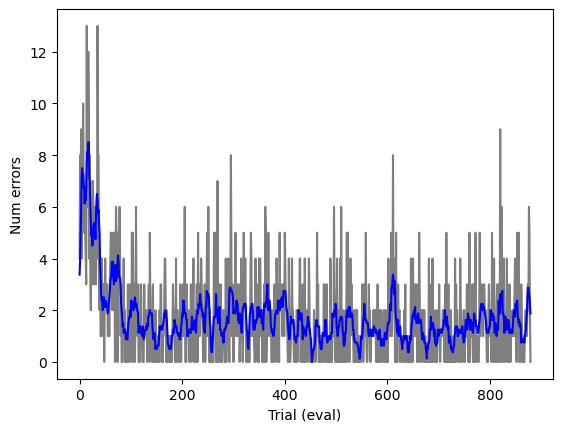

In [90]:
k = 8
errors = num_errors_list

kernel = np.ones(k) / k
errors_smoothed = np.convolve(errors, kernel, mode='same')

plt.plot(errors, alpha=0.5, color='k')
plt.plot(errors_smoothed, color='blue')
plt.xlabel("Trial (eval)")
plt.ylabel("Num errors")

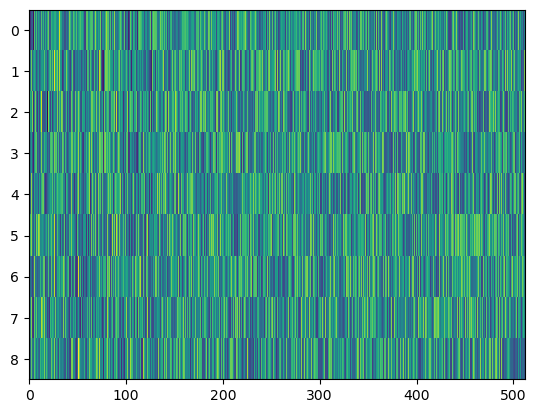

In [91]:
out_chan = 1000

weight = model.model.encoder.conv1.weight[out_chan, :, :].cpu().detach().numpy()

plt.imshow(weight.T, aspect='auto', interpolation='none')